Here are some $\LaTeX$ macros (you can't see them, but when you evaluate this cell they are loaded into memory and you can use them later).
$$
\newcommand{\dd}{\mathrm{d}}
\newcommand{\diff}[2]{\frac{ \dd #1 } {\frac \dd #2}}
\newcommand{\chieff}{\chi_\mathrm{eff}}
\newcommand{\piso}{p_\mathrm{iso}}
\newcommand{\pali}{p_\mathrm{ali}}
$$

In [1]:
using PyCall
using PyPlot

@pyimport seaborn as sns
sns.set_style("ticks")
sns.set_palette("colorblind")
sns.set_context("notebook")

Cole had a great idea, the thrust of which is the following: assume that you have some distribution for the spin magnitudes of black holes (and it is common to the more- and less-massive BH in any binary).  The distribution of $\chieff$ that is implied by this magnitude distribution differs depending on whether you assume that the angular distribution is isotropic or aligned.  For example, when the magnitude distribution is flat, $p(a) = 1$, the isotropic angle assumption implies that 
$$
\piso\left( \chieff \right) = -\frac{\log \left| \chieff \right|}{2},
$$
while the aligned assumption implies that
$$
\pali\left( \chieff \right) = \begin{cases}
1 & \chieff > 0 \\
0 & \chieff < 0
\end{cases}
$$

As an aside: here is how to derive the $\chieff$ distribution under the isotropic assumption for any $p(a)$.  If we assume:

 * The magnitude distribution for both objects' spin is the same $p(a)$.
 * The angular distribution for both objects' spin is isotropic.
 
Then $\chieff$ is equal to the product of $a$ with a uniform random variable on $[-1,1]$ ($\iota = \cos \theta$, with $\theta$ the colatitude on a sphere).  Therefore 
$$
p\left( \chieff \right) = \int_{-1}^{1} \dd \iota \, \int_0^1 \dd a \, \delta\left( \chieff - a \iota \right) \frac{p(a)}{2} = \int_{-1}^{1} \dd \iota \, \int_0^1 \dd a \, \frac{\delta\left( a - \frac{\chieff}{\iota} \right)}{\left| \iota \right|} \frac{p(a)}{2}.
$$
Now, noting that the distribution of $\chieff$ is an even function, assume that $\chieff > 0$; since $0 \leq a \leq 1$, we must have $\iota \geq \chieff$ if the $\delta$-function is to be "activated," so
$$
p\left( \chieff \right) = \int_{\chieff}^1 \dd \iota \, \frac{p\left( \frac{\chieff}{\iota} \right)}{2 \iota}.
$$
The even assumption implies 
$$
p\left( \chieff \right) = \int_{\left| \chieff \right|}^1 \dd \iota \, \frac{p\left( \frac{\left|\chieff\right|}{\iota} \right)}{2 \iota}
$$

Here is some code that implements distributions for $p(a) = 1$, $p(a) = 2 a$, and $p(a) = 2(1-a)$; these are flat, increasing, and decreasing, respectively.

In [2]:
function p_iso_flat(chieff)
    -0.5*log(abs(chieff))
end
function p_ali_flat(chieff)
    if chieff > 0
        1.0
    else
        0.0
    end
end

function p_iso_inc(chieff)
    1.0 - abs(chieff)
end
function p_ali_inc(chieff)
    if chieff > 0
        2.0*chieff
    else
        0.0
    end
end

function p_iso_dec(chieff)
    abs(chieff)-log(abs(chieff))-1.0
end
function p_ali_dec(chieff)
    if chieff > 0
        2.0*(1.0-chieff)
    else
        0.0
    end
end

p_ali_dec (generic function with 1 method)

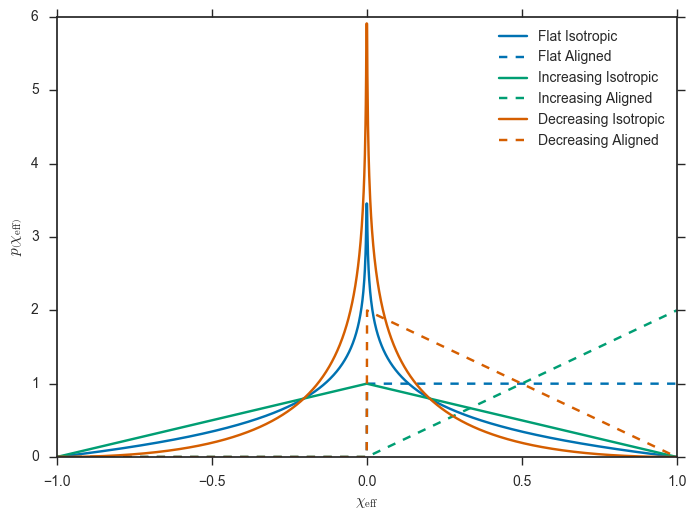

PyObject <matplotlib.text.Text object at 0x332eee048>

In [8]:
chieffs = collect(-1:0.001:1)

plot(chieffs, p_iso_flat.(chieffs), "-", color=sns.color_palette()[1], label="Flat Isotropic")
plot(chieffs, p_ali_flat.(chieffs), "--", color=sns.color_palette()[1], label="Flat Aligned")

plot(chieffs, p_iso_inc.(chieffs), "-", color=sns.color_palette()[2], label="Increasing Isotropic")
plot(chieffs, p_ali_inc.(chieffs), "--", color=sns.color_palette()[2], label="Increasing Aligned")

plot(chieffs, p_iso_dec.(chieffs), "-", color=sns.color_palette()[3], label="Decreasing Isotropic")
plot(chieffs, p_ali_dec.(chieffs), "--", color=sns.color_palette()[3], label="Decreasing Aligned")

legend(loc="best")
xlabel(L"$\chi_\mathrm{eff}$")
ylabel(L"$p\left( \chi_\mathrm{eff}\right)$")

## Hierarchical Analysis

LIGO measures $\chieff$ better than any other spin parameter, but still with significant uncertainty, so we need to properly incorporate measurement uncertainty in our analysis; thus our analysis must be *hierarchical*.  In a hierarchical analysis, we assume that each event has a true, but unknown, value of the effective spin, drawn from the population distribution, which may have some parameters $\lambda$; then the system is observed, represented by the likelihood function, which results in a distribution for the true effective spin (and all other paremeters describing the system) consistent with the data.  Combining, the *joint* posterior on each system's $\chieff^i$ parameters and the population parameters $\lambda$ implied by a set of observations each with data $d^i$, is 
$$
p\left( \left\{ \chieff^i \right\}, \lambda \mid \left\{ d^i \right\} \right) \propto \left[ \prod_{i=1}^{N_\mathrm{obs}} p\left(d^i \mid \chieff^i \right) p\left( \chieff^i \mid \lambda \right) \right] p\left(\lambda\right).
$$

The components of this formula are

 * The GW (marginal) likelihood, $p\left(d \mid \chieff\right)$.  "Marginal" because we are (implicitly) *integrating* over all parameters of the signal but $\chieff$.  Note that it is the *likelihood*, not the *posterior* that matters for the hierarchical analysis; if we are given posterior distributions or posterior samples, we need to re-weight to "remove" the prior and obtain the likelihood.
 * The population distribution for $\chieff$, $p\left( \chieff \mid \lambda \right)$.  This function can be parameterised by population-level parameters, $\lambda$.  (In the cases discussed above, there are no parameters for the population.)
 * The prior on the population-level parameters, $p(\lambda)$.
 
If we don't care about the individual event $\chieff$ paremetrs, we can integrate them out, obtaining 
$$
p\left( \lambda \mid \left\{ d^i \right\} \right) \propto \left[ \prod_{i=1}^{N_\mathrm{obs}} \int \dd \chieff^i \, p\left(d^i \mid \chieff^i \right) p\left( \chieff^i \mid \lambda \right) \right] p\left(\lambda\right).
$$
If we are given posterior samples of $\chieff^{ij}$ ($i$ labels the event, $j$ labels the particular posterior sample) drawn from an analysis using a prior $p\left( \chieff \right)$, then we can approximate the integral by an re-weighted average of the population distribution over the samples:
$$
p\left( \lambda \mid \left\{ d^i \right\} \right) \propto \left[ \prod_{i=1}^{N_\mathrm{obs}} \frac{1}{N_i} \sum_{j=1}^{N_i} \frac{p\left( \chieff^{ij} \mid \lambda \right)}{p\left( \chieff^{ij} \right)} \right] p\left(\lambda\right).
$$

In a fully-spinning `LALInference` analysis, our prior for $\chieff$ is given by the combination of a flat prior in the spin magnitudes with an isotropic prior in angles:
$$
p\left( \chieff \right) = -\frac{\log \left| \chieff \right|}{2}.
$$
The code below computes the marginal likelihood for a population model with distribution `p_chieff` using a list of posterior samples from `LALInference` runs on a set of observations using the above re-weighted average formula:

In [9]:
function marginal_model_likelihood(chieff_samples, p_chieff)
    ll = 0.0
    for ce in chieff_samples
        ll += log(mean(p_chieff.(ce) ./ p_iso_flat.(ce))) # p_iso_flat is the LALInference prior
    end
    ll
end

marginal_model_likelihood (generic function with 1 method)

## Mock Analysis of the 2.9 LIGO Events

We will mock up some distributions for the LIGO events.  We will use the median and 90% intervals from the [O1 BBH Paper](https://arxiv.org/abs/1606.04856).

In [10]:
function ninetyrange_to_musigma(med, upper_interval, lower_interval)
    sigma = (upper_interval + lower_interval)/3.29  # The 90% interval of a Gaussian ~ 3.29*sigma
    (med, sigma)
end

ninetyrange_to_musigma (generic function with 1 method)

In [11]:
muGW150914, sigmaGW150914 = ninetyrange_to_musigma(-0.06, 0.14, 0.14)
muLVT151012, sigmaLVT151012 = ninetyrange_to_musigma(0.0, 0.3, 0.2)
muGW151226, sigmaGW151226 = ninetyrange_to_musigma(0.21, 0.2, 0.1)

(0.21,0.09118541033434652)

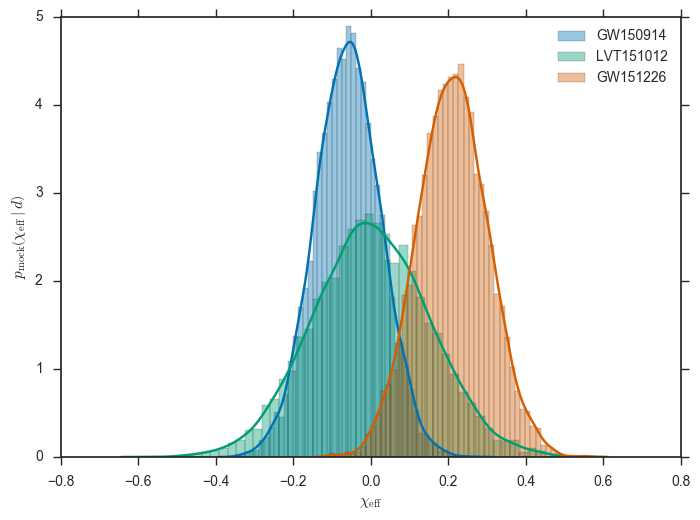

PyObject <matplotlib.text.Text object at 0x338063da0>

In [14]:
mocksamples = [mu + sigma*randn(10000) for (mu, sigma) in zip([muGW150914, muLVT151012, muGW151226], [sigmaGW150914, sigmaLVT151012, sigmaGW151226])]
evtnames = ["GW150914", "LVT151012", "GW151226"]
for (s,n) in zip(mocksamples, evtnames)
    sns.distplot(s, label=n)
end
legend(loc="best")
xlabel(L"$\chi_\mathrm{eff}$")
ylabel(L"$p_\mathrm{mock}\left( \chi_\mathrm{eff} \mid d \right)$")

The key to this plot: 

 * First letter `{"F", "I", "D"}` => flat magnitude distribution, increasing magnitude distribution, decreasing magnitude distribution.
 * Second letter `{"I", "A"}` => isotropic angle distribution, aligned (positive) angle distribution

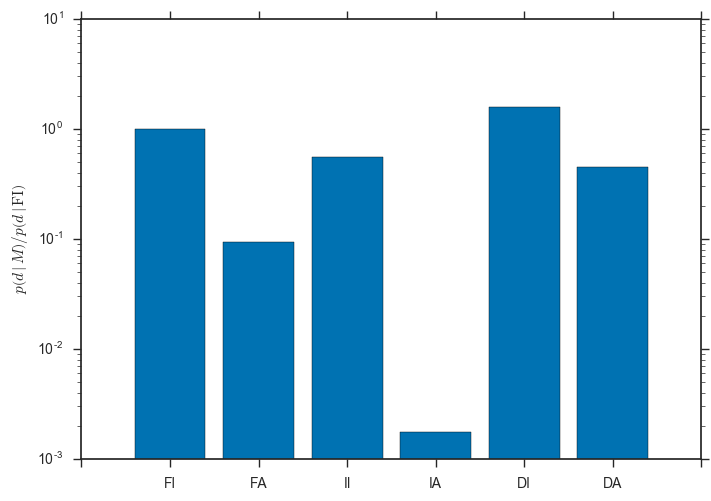

PyObject <matplotlib.text.Text object at 0x338832d30>

In [29]:
ll_iso_flat = marginal_model_likelihood(mocksamples, p_iso_flat)
ll_ali_flat = marginal_model_likelihood(mocksamples, p_ali_flat)
ll_iso_inc = marginal_model_likelihood(mocksamples, p_iso_inc)
ll_ali_inc = marginal_model_likelihood(mocksamples, p_ali_inc)
ll_iso_dec = marginal_model_likelihood(mocksamples, p_iso_dec)
ll_ali_dec = marginal_model_likelihood(mocksamples, p_ali_dec)

xs = collect(1:6)

bar(xs, exp([ll_iso_flat, ll_ali_flat, ll_iso_inc, ll_ali_inc, ll_iso_dec, ll_ali_dec]), align="center")
yscale("log")

gca()[:set_xticklabels](["", "FI", "FA", "II", "IA", "DI", "DA", ""])
ylabel(L"$p\left( d \mid M \right) / p\left( d \mid \mathrm{FI} \right)$")